In [29]:
%matplotlib inline

from __future__ import print_function

import numpy as np
from sklearn.model_selection import train_test_split
from dataproc_utils import load_wordvecs, load_file, read_proc_data
from dataproc_utils import make_word_freq_V, word2idx
from dataproc_utils import vocab_vectorizer, random_sampler
from tfidf_cosine_similarity import tfidf_fit_transform

import keras
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Reshape, Dropout
from keras.layers import dot, multiply, concatenate
from keras.layers import LSTM, Conv1D, TimeDistributed, Lambda
from keras.initializers import Constant
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from dataproc_utils import plot_confusion_matrix, compute_weighted_accuracy

from collections import Counter
from matplotlib import pyplot as plt

# Global variables

In [30]:
batch_size = 128
epochs = 15
random_state = 42
n_pars = 9 # max number of paragraphs from each document
par_size = 15  # max paragraph length (num of words in each paragraph)
claim_size = 15  # max num of words in each claim
embedding_dim = 100  # size of the pre-trained glove embeddings
output_size = 4  # size of the output vector, corresponds to the number of classes

# Embeddings from Glove

Only the words we use

In [31]:
# open saved wordvecs from file
w2v = load_wordvecs('twitter_glo_vecs\\train_wordvecs100d.txt')
print(len(w2v), 'pretrained embeddings')

# load data and labels
bodies_train = load_file('processed_data\\train_bodies.txt')
claims_train = load_file('processed_data\\train_claims.txt')
bodies_test = load_file('processed_data\\test_bodies.txt')
claims_test = load_file('processed_data\\test_claims.txt')

data_train = read_proc_data(bodies_train, claims_train, split_pars=True)
y_train = np.array([label for _, _, label in data_train])

data_test = read_proc_data(bodies_test, claims_test, split_pars=True)
y_test = np.array([label for _, _, label in data_test])

# train/validation split
train_data, val_data, train_labels, val_labels = train_test_split(data_train, y_train,
                                                                  test_size=.2,
                                                                  random_state=random_state)

# compute cos similarities after splitting into train/val or load the precomputed ones
# you have to recompute the similarities each time you change the random state or size of train/val split
# train_p_tfidf, val_p_tfidf, test_p_tfidf = tfidf_fit_transform(train_data, val_data, data_test)

# load pre-computed p_tfidf similarity matrix for train data
train_p_tfidf = np.loadtxt('processed_data\\p_tfidf_train.txt', dtype=np.float32)
val_p_tfidf = np.loadtxt('processed_data\\p_tfidf_val.txt', dtype=np.float32)
test_p_tfidf = np.loadtxt('processed_data\\p_tfidf_test.txt', dtype=np.float32)
print('Shape of similarity matrix train p_tfidf:', train_p_tfidf.shape)


# create a vocabulary dict from train data (we exclude rare words, which appear only once)
word2freq = make_word_freq_V(train_data, fmin=1)
word2index = word2idx(word2freq, pretrained=w2v)
vocab_size = len(word2index)
print('Vocab size:', vocab_size, 'unique words in the train set which have glove embeddings')

# vectorize input words (turn each word into its index from the word2index dict)
# for new words in test set that don't appear in train set, use index of <unknown>
train_body, train_claim = vocab_vectorizer(train_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
val_body, val_claim = vocab_vectorizer(val_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
test_body, test_claim = vocab_vectorizer(data_test, word2index, max_par_len=par_size, max_claim_len=claim_size)

17354 pretrained embeddings
Shape of similarity matrix train p_tfidf: (39977, 9)
Vocab size: 17256 unique words in the train set which have glove embeddings


# Oversampling

In [32]:
# perform random under/over sampling to prevent class imbalance
# over-sampling shows better results
train_body, train_claim, train_p_tfidf, train_labels = random_sampler(train_body,
                                                                      train_claim,
                                                                      train_p_tfidf,
                                                                      train_labels, type='over')

In [33]:
np.save('bodies.npy', [train_body, val_body, test_body])
np.save('claims.npy', [train_claim, val_claim, test_claim])
np.save('ptfidf.npy', [train_p_tfidf, val_p_tfidf, test_p_tfidf])
np.save('labels.npy', [train_labels, val_labels, y_test])

In [34]:
train_body, val_body, test_body = np.load('bodies.npy')
train_claim, val_claim, test_claim = np.load('claims.npy')
train_p_tfidf, val_p_tfidf, test_p_tfidf = np.load('ptfidf.npy')
train_labels, val_labels, test_labels = np.load('labels.npy')

In [35]:
# prepare embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for w, i in word2index.items():
    embedding_matrix[i] = w2v[w]

# Embeddings

In [36]:
# load pre-trained word vectors into embedding layers
# we set trainable to false to keep the embeddings fixed
embedding_body = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=(n_pars, par_size,),
                            trainable=False)

embedding_claim = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=claim_size,
                            trainable=False)

In [37]:
# initialize input placeholders and embed pre-trained word vectors
input_body = Input(shape=(n_pars, par_size,), dtype='int32', name='docs')
input_claim = Input(shape=(claim_size,), dtype='int32', name='claims')
input_p_tfidf = Input(shape=(n_pars,), dtype='float32', name='tfidf')

print('input body', input_body.shape)     # (?, 9, 15)
print('input claim', input_claim.shape)    # (?, 15)
print('input p_tfidf', input_p_tfidf.shape)  # (?, 9)

input body (?, 9, 15)
input claim (?, 15)
input p_tfidf (?, 9)


In [38]:
embedded_body = embedding_body(input_body)
embedded_claim = embedding_claim(input_claim)

print('embedded body', embedded_body.shape)   # (?, 9, 15, 25)
print('embedded claim', embedded_claim.shape)  # (?, 15, 25)

embedded body (?, 9, 15, 100)
embedded claim (?, 15, 100)


# CNNs

## Paragraphs

In [39]:
# train two 1D convnets (should be time distributed with maxout layer)
cnn_body = TimeDistributed(Conv1D(100, 5, padding='valid', activation='relu'), name='CNN_docs')(embedded_body)
cnn_body = Lambda(lambda x: K.max(x, axis=-1, keepdims=False), name='CNN_maxout_docs')(cnn_body)  # maxout
#cnn_body = Lambda(lambda x: tf.contrib.layers.maxout(x, num_units=1))(cnn_body) ## does not work for some reason

## Claims

In [40]:
cnn_claim = Conv1D(100, 5, padding='valid', activation='relu', name='CNN_claims')(embedded_claim)
cnn_claim = Lambda(lambda x: K.max(x, axis=-1, keepdims=False), name='CNN_maxout_claims')(cnn_claim)  # maxout
#cnn_claim = Lambda(lambda x: tf.contrib.layers.maxout(x, num_units=1))(cnn_claim) ## does not work

For Maxout, we take the maximum value of the 100 values in the vector extracted by the CNN

In [41]:
# maxout eliminates the last dimension from the cnn representations:
# converts cnn_body with shape (?, 9, 11, 100) to (?, 9, 11)
# and cnn_claim with shape (?, 11, 100) to (?, 11)
print('cnn_body shape', cnn_body.shape)  # (?, 9, 11)
print('cnn_claim shape', cnn_claim.shape)  # (?, 11)

cnn_body shape (?, 9, 11)
cnn_claim shape (?, 11)


# LSTMs

- TimeDistributed for documents
- simple for claims

In [42]:
# train two lstms
lstm_body = TimeDistributed(LSTM(100), name="LSTM_docs")(embedded_body)
lstm_claim = (LSTM(100, name="LSTM_claims"))(embedded_claim)

print('lstm body', lstm_body.shape) # (?, 9, 100)
print('lstm claim', lstm_claim.shape) # (?, 100)

lstm body (?, 9, 100)
lstm claim (?, 100)


In [43]:
# reshape tfidf sim matrix layer from (?, 9) into (?, 9, 1)
reshaped_p_tfidf = Reshape((n_pars, 1), name="reshape_tfidf")(input_p_tfidf)
lstm_body = multiply([lstm_body, reshaped_p_tfidf], name="")
### tensor shapes: (samples, n_pars, 100) * (samples, n_pars, 1) => (?, 9, 100)
print('lstm_body * p_tfidf', lstm_body.shape)  # (?, 9, 100)

lstm_body * p_tfidf (?, 9, 100)


# P_lstm

In [44]:
## p_lstm = lstm_claim.T x M x lstm_body[j] 
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_lstm = dot([lstm_body, lstm_claim], axes=(2, 1), normalize=True, name="P_lstm")
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9)


In [45]:
### cnn_body = cnn_body * p_lstm
# reshape sim matrix layer from (?, 9) into (?, 9, 1)
p_lstm = Reshape((n_pars, 1), name="P_lstm_reshape")(p_lstm)

In [46]:
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9, 1)


# P_cnn

In [47]:
cnn_body = multiply([cnn_body, p_lstm])
print('cnn_body * p_lstm', cnn_body.shape) # (?, 9, 11)
print('cnn_claim', cnn_claim.shape)        # (?, 11)

cnn_body * p_lstm (?, 9, 11)
cnn_claim (?, 11)


In [48]:
## p_cnn = cnn_claim.T x M' x cnn_body[j] 
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_cnn = dot([cnn_body, cnn_claim], axes=(2, 1), normalize=True, name="P_cnn")
print('p_cnn', p_cnn.shape)  # (?, 9)

p_cnn (?, 9)


In [49]:
## o = [mean(cnn_body); [max(p_cnn); mean(p_cnn)]; [max(p_lstm); mean(p_lstm)]; [max(p_tfidf); mean(p_tfidf)]]
mean_cnn_body = Lambda(lambda x: K.mean(x, axis=2), name="mean_cnn_body")(cnn_body)
print('mean cnn body', mean_cnn_body.shape)  # (?, 9)

mean cnn body (?, 9)


# O

In [50]:
# taking mean and max similarities
max_p_cnn = Lambda(lambda x: K.max(x, axis=1), name="max_p_cnn")(p_cnn)
mean_p_cnn = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_cnn")(p_cnn)
max_p_lstm = Lambda(lambda x: K.max(x, axis=1), name="max_p_lstm")(p_lstm)
mean_p_lstm = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_lstm")(p_lstm)
max_p_tfidf = Lambda(lambda x: K.max(x, axis=1), name="max_p_tfidf")(reshaped_p_tfidf)
mean_p_tfidf = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_tfidf")(reshaped_p_tfidf)

In [51]:
# reshape some layers to make their dimensions compatible
max_p_cnn = Reshape((1,), name="max_p_cnn_reshape")(max_p_cnn)
mean_p_cnn = Reshape((1,), name="mean_p_cnn_reshape")(mean_p_cnn)

In [52]:
output = concatenate([mean_cnn_body,
                      max_p_cnn, mean_p_cnn,
                      max_p_lstm, mean_p_lstm,
                      max_p_tfidf, mean_p_tfidf],
                      name="O_concatenate")

print('output', output.shape)  # (?, 15)

output (?, 15)


In [53]:
response = concatenate([output, lstm_claim, cnn_claim], name="input_for_dense_R")
print('response layer:', response.shape)   # (?, 126)

response layer: (?, 126)


In [54]:
# home stretch
stance = Dense(300, activation='relu', name="dense")(response)
stance = Dropout(0.7)(stance)
preds = Dense(output_size, activation='softmax')(stance)

In [55]:
# build the model
model = Model([input_body, input_claim, input_p_tfidf], preds)
model.compile(optimizer=keras.optimizers.adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Diagram of model

In [56]:
# uncomment the line below to plot the model diagram (requires graphviz)
# keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# Train

In [57]:
filepath="model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [59]:
# train
history = model.fit(
    [train_body, train_claim, train_p_tfidf], train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_body, val_claim, val_p_tfidf], val_labels),
    callbacks=[checkpoint],
    verbose=2
         )

Train on 116848 samples, validate on 9995 samples
Epoch 1/15
 - 293s - loss: 0.5644 - acc: 0.7812 - val_loss: 0.2366 - val_acc: 0.9184

Epoch 00001: val_acc improved from -inf to 0.91836, saving model to model.hdf5
Epoch 2/15
 - 296s - loss: 0.1461 - acc: 0.9534 - val_loss: 0.1949 - val_acc: 0.9439

Epoch 00002: val_acc improved from 0.91836 to 0.94387, saving model to model.hdf5
Epoch 3/15
 - 300s - loss: 0.0672 - acc: 0.9790 - val_loss: 0.2010 - val_acc: 0.9467

Epoch 00003: val_acc improved from 0.94387 to 0.94667, saving model to model.hdf5
Epoch 4/15
 - 299s - loss: 0.0446 - acc: 0.9859 - val_loss: 0.2099 - val_acc: 0.9520

Epoch 00004: val_acc improved from 0.94667 to 0.95198, saving model to model.hdf5
Epoch 5/15
 - 301s - loss: 0.0353 - acc: 0.9885 - val_loss: 0.2006 - val_acc: 0.9569

Epoch 00005: val_acc improved from 0.95198 to 0.95688, saving model to model.hdf5
Epoch 6/15
 - 302s - loss: 0.0308 - acc: 0.9906 - val_loss: 0.1973 - val_acc: 0.9578

Epoch 00006: val_acc improv

In [60]:
test_claim.shape, y_test.shape

((25413, 15), (25413,))

In [61]:
model.load_weights(filepath)

In [62]:
preds = model.predict([test_body, test_claim, test_p_tfidf])

In [63]:
preds = np.argmax(preds, axis=1)

# Metrics

In [64]:
f1_score(y_test, preds, average='macro')

0.5019925165346772

In [65]:
precision_recall_fscore_support(y_test, preds, average=None)

(array([0.94133434, 0.61709534, 0.43132888, 0.0719697 ]),
 array([0.95580141, 0.71482975, 0.30530741, 0.02725968]),
 array([0.94851271, 0.66237675, 0.35753846, 0.03954214]),
 array([18349,  4464,  1903,   697], dtype=int64))

In [66]:
precision_recall_fscore_support(y_test, preds, average='macro')

(0.5154320626501296, 0.5007995622225799, 0.5019925165346772, None)

In [67]:
score = model.evaluate([test_body, test_claim, test_p_tfidf], y_test, batch_size=batch_size, verbose=2)

# Confusion matrix

In [68]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3407743071053717
Test accuracy: 0.839294849111161


Normalized confusion matrix


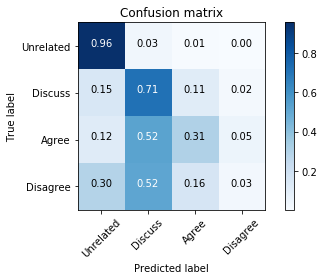

In [69]:
cnf_matrix = confusion_matrix(y_test, preds)
fig = plot_confusion_matrix(cnf_matrix, ['Unrelated','Discuss','Agree','Disagree'], normalize=True)

# Balancing the results

In [70]:
compute_weighted_accuracy(y_test, preds)

0.7484604656152773

# Plot training

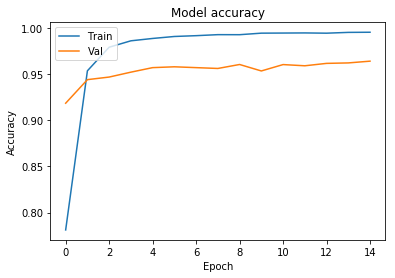

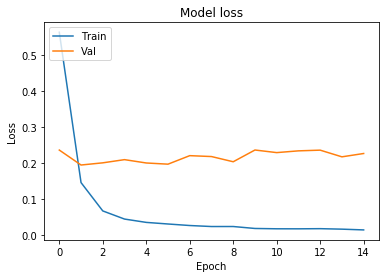

In [71]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Exploring model layers

In [72]:
index2word = {index:word for word,index in word2index.items()}

In [73]:
index2word[0] = ''

In [75]:
import tqdm
import pandas as pd

In [76]:
import pdb

In [77]:
test_data = [test_body, test_claim, test_p_tfidf]
predicted_all = model.predict(test_data)

In [78]:
examples = []


for NR_ENTRY in tqdm.tqdm(range(len(test_body))):
    
    predicted = np.argmax(predicted_all[NR_ENTRY])
    
    stances = {
        2: 'agree',
        3: 'disagree'
    }
    
    
    
    if (test_labels[NR_ENTRY] == 3 or test_labels[NR_ENTRY] == 2) and test_labels[NR_ENTRY] == predicted:
        one_input = [[test_body[NR_ENTRY]], [test_claim[NR_ENTRY]], [test_p_tfidf[NR_ENTRY]]]
        p_cnn_layer_model = Model(inputs=model.input,
                                         outputs=model.get_layer('P_cnn').output)

        p_cnn_pred = p_cnn_layer_model.predict(one_input)

        most_sim_paragraph_index = p_cnn_pred.argmax()

        most_sim_paragraph = [index2word[w] for w in one_input[0][0][most_sim_paragraph_index]]

        claim = ' '.join([str(index2word[w]) if w!=0 else '' for w in one_input[1][0]])

        cnn_maxout_layer_model = Model(inputs=model.input,
                                         outputs=model.get_layer('CNN_maxout_docs').output)

        cnn_maxout_pred = cnn_maxout_layer_model.predict(one_input)

        ngramindex = cnn_maxout_pred[0][most_sim_paragraph_index].argmax()
        #     df.loc[df['Stance'] == 'agree', 'Stance'] = 2
        #     df.loc[df['Stance'] == 'disagree', 'Stance'] = 3
        most_sim_ngram = ' '.join(most_sim_paragraph[ngramindex:ngramindex+5])
        most_sim_para = ' '.join(most_sim_paragraph)

        predicted_text = stances[predicted]
        actual_text = stances[test_labels[NR_ENTRY]]
        #         pdb.set_trace()
        examples.append([NR_ENTRY, claim, most_sim_ngram, most_sim_para, predicted_text, actual_text])

100%|████████████████████████████████████████████████████████████████████████████| 25413/25413 [06:39<00:00, 63.62it/s]


In [133]:
df = pd.DataFrame(examples, columns=['claim nr', 'claim', 'most sim ngram', 'most sim paragraph', 'predicted stance', 'actual stance'])

In [80]:
df.to_csv("examples.csv")

In [135]:
pd.options.display.max_colwidth = 100
df.replace('\s{14}', np.nan, inplace=True, regex=True)
df.dropna(inplace=True)
df.tail(20)

,claim nr,claim,most sim ngram,most sim paragraph,predicted stance,actual stance
578,25239,everyone was wrong <unknown> fat can be good for you,fat and whether it is,this article takes a detailed look at <unknown> fat and whether it is good or,agree,agree
579,25253,high intensity training does more harm than good raising the risk of cancer and heart,form of exercise the <unknown>,but if a person isnt accustomed to this form of exercise the <unknown> could be,agree,agree
580,25266,scoop trump tells <unknown> us will quit paris climate deal,to air on cbs sunday,speaking of uncertainty in a face the nation interview set to air on cbs sunday,agree,agree
581,25267,scoop trump tells <unknown> us will quit paris climate deal,announce he is pulling the,trump could announce he is pulling the us from the deal which would trigger a,agree,agree
582,25269,scoop trump tells <unknown> us will quit paris climate deal,'s <unknown> venting and <unknown>,the clean power plan the bureau of land management 's <unknown> venting and <unknown> regulation,agree,agree
583,25272,for president trump pulling out of paris is the only logical move,to air on cbs sunday,speaking of uncertainty in a face the nation interview set to air on cbs sunday,agree,agree
584,25289,donald trump walks back campaign pledges on another issue climate change,degrees <unknown> or <number> degrees,it also contains an even more stringent target of <number> degrees <unknown> or <number> degrees,agree,agree
585,25303,fake news wapo made-up <unknown> request for permanent back channel communication with russia,way to <unknown> <unknown> discussions,<unknown> suggested the use of russian diplomatic facilities as a way to <unknown> <unknown> dis...,agree,agree
588,25336,<number> <unknown> studies proving gmos can be <unknown> to human health,ever tells you that we,if anybody ever tells you that we know with one hundred percent certainty that gmos,agree,agree
589,25340,<number> studies proving gmos are <unknown> not if science matters,presented just a bit of,below ive presented just a bit of information to get you started on your research,disagree,disagree
